# Outfit Generation
- Take in an image and return a style board

In [1]:
import json
import numpy as np
import numpy.linalg as la
import torch

from IPython.display import display
from PIL import Image
from rembg import remove

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from transformers import AutoTokenizer, BertTokenizer, BertModel, DistilBertForMultipleChoice, MobileBertForMultipleChoice, AutoConfig, AutoModelForMultipleChoice, AutoTokenizer, LongformerForMultipleChoice, AutoModelForImageClassification, AutoImageProcessor
from collections import Counter

### Load in embeddings and models

In [2]:
# Data paths
data_dir = "../polyvore_outfits/"

embeddings_path = data_dir + "embeddings.npy"
filenames_path = data_dir + "filenames.txt"
images_path = data_dir + "images/"
item_metadata_path = data_dir + "item_metadata.json"
outfits_metadata_path = data_dir + "outfits_metadata.json"
categories_path = data_dir + "categories.csv"
local_categories_path = data_dir + "local_category_map.json"


In [3]:
# Load in embeddings
embeddings = np.load(embeddings_path)
filenames_file = open(filenames_path, 'r')
filenames = [line.strip() for line in filenames_file.readlines()]

# Error checking
if len(embeddings) != len(filenames):
    print("STOP. The lengths of embeddings and filenames don't match")
    print(len(embeddings), len(filenames))

In [4]:
# Load in outfits
outfits_file = open(outfits_metadata_path, 'r')
outfit_map = json.load(outfits_file)

items_file = open(item_metadata_path, 'r')
items_map = json.load(items_file)

In [5]:
# Load in categories
categories_file = open(categories_path)
category_map = {}
for line in categories_file:
    parts = line.strip().split(',')
    category_map[int(parts[0])] = tuple(parts[1:])

# Mapping from local to server categories
local_category_file = open(local_categories_path, 'r')
local_to_server_category_map = json.load(local_category_file)

# Error Checking
for key, value in local_to_server_category_map.items():
    for key2 in value['mapping']:
        if key2 not in category_map:
            print(category_map)
            print(key2, "is a Missing category")


In [6]:
# Inverted index from image to boards they are part of
item_to_outfits = {}

for outfit_id, metadata in outfit_map.items():
    for item in metadata['items']:
        item_id = item['item_id']
        item_to_outfits[item_id] = item_to_outfits.get(item_id, []) + [outfit_id]

In [8]:
# Embedding model
emb_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
emb_model.trainable = False
emb_model = Sequential([emb_model, GlobalMaxPooling2D()])

### Narrow Scope of Color Inference

### Run Local Inference Models

In [11]:
def remove_background(image_path):
    try:
        img = Image.open(image_path)
        img_without_bg = remove(img)
        return img_without_bg.resize((224, 224)).convert("RGB")
    except Exception as e:
        print(f"Error removing background: {e}")
        return None
    
ex_img = "jeans.png"

# No remove image background
img = Image.open(ex_img)
image = img.resize((224, 224)).convert("RGB")

In [12]:
def get_embeddings(img):
    # Normalize image
    img_array = kimage.img_to_array(img)
    expand_img = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expand_img)

    # Run prediction
    result_to_resnet = emb_model.predict(preprocessed_img)
    flatten_result = result_to_resnet.flatten()
    result_normalized = flatten_result / la.norm(flatten_result)

    return result_normalized

img_embeddings = get_embeddings(image)

### Run nearest neighbors on intersection

In [13]:
neighbors = NearestNeighbors(n_neighbors = 6, algorithm='brute', metric='euclidean')
neighbors.fit(embeddings)
distance, indices = neighbors.kneighbors([img_embeddings])

In [14]:
def displayBoard(key):
    # Size hyperparameters
    num_items = len(outfit_map[key]['items'])
    image_width = 1000

    # Conglomerated info
    concatenated_image = np.zeros((image_width, 0, 3), dtype=np.uint8)
    item_descriptions = []
        
    # print("Title:", outfit_map[key]['title'])

    for ids in outfit_map[key]['items']:
        # Get the image
        path = "../polyvore_outfits/images/" + ids['item_id'] + ".jpg"
        image = Image.open(path)

        # Resize
        image = image.resize((image_width, image_width), Image.LANCZOS)
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

        description = items_map[ids['item_id']]['url_name'] + " (" + items_map[ids['item_id']]['semantic_category'] + ")"
        item_descriptions.append(description)

    # Display board
    plt.figure(figsize=(image_width * num_items / 100, image_width / 100))  # Adjusted figure size
    plt.imshow(concatenated_image)
    plt.axis('off')

    # plt.savefig(outfit_map[key]['title'])
    plt.show()

    # print("Items:", item_descriptions)

In [15]:
def get_descriptions_from_outfits(key):
    # Size hyperparameters
    num_items = len(outfit_map[key]['items'])
    image_width = 1000

    # Conglomerated info
    concatenated_image = np.zeros((image_width, 0, 3), dtype=np.uint8)
    item_descriptions = []
        
    # print("Title:", outfit_map[key]['title'])

    for ids in outfit_map[key]['items']:
        # Get the image
        path = "../polyvore_outfits/images/" + ids['item_id'] + ".jpg"
        image = Image.open(path)

        # Resize
        image = image.resize((image_width, image_width), Image.LANCZOS)
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

        description = items_map[ids['item_id']]['url_name'] + " (" + items_map[ids['item_id']]['semantic_category'] + ")"
        item_descriptions.append(description)
        
    return item_descriptions

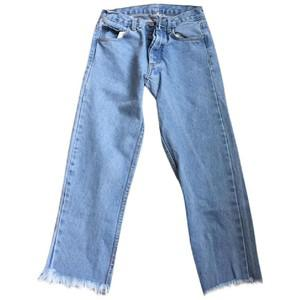

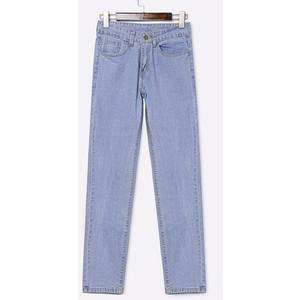

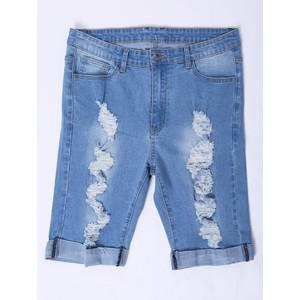

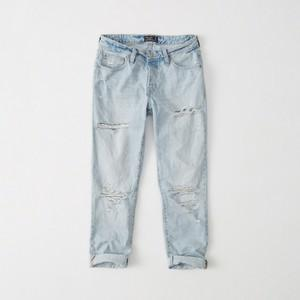

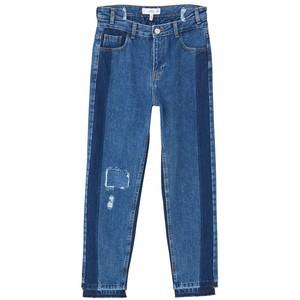

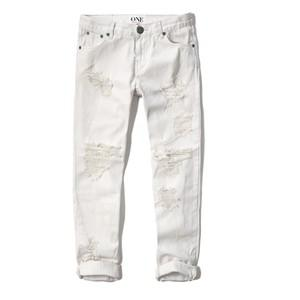

In [16]:
boards = []
for file_idx in indices[0]:
    img = Image.open(images_path + filenames[file_idx])
    img_path = filenames[file_idx][:-4]
    img_board = item_to_outfits.get(img_path, [])
    boards.extend(img_board)
    
    # img.save(str(file_idx) + ".png")
    display(img)

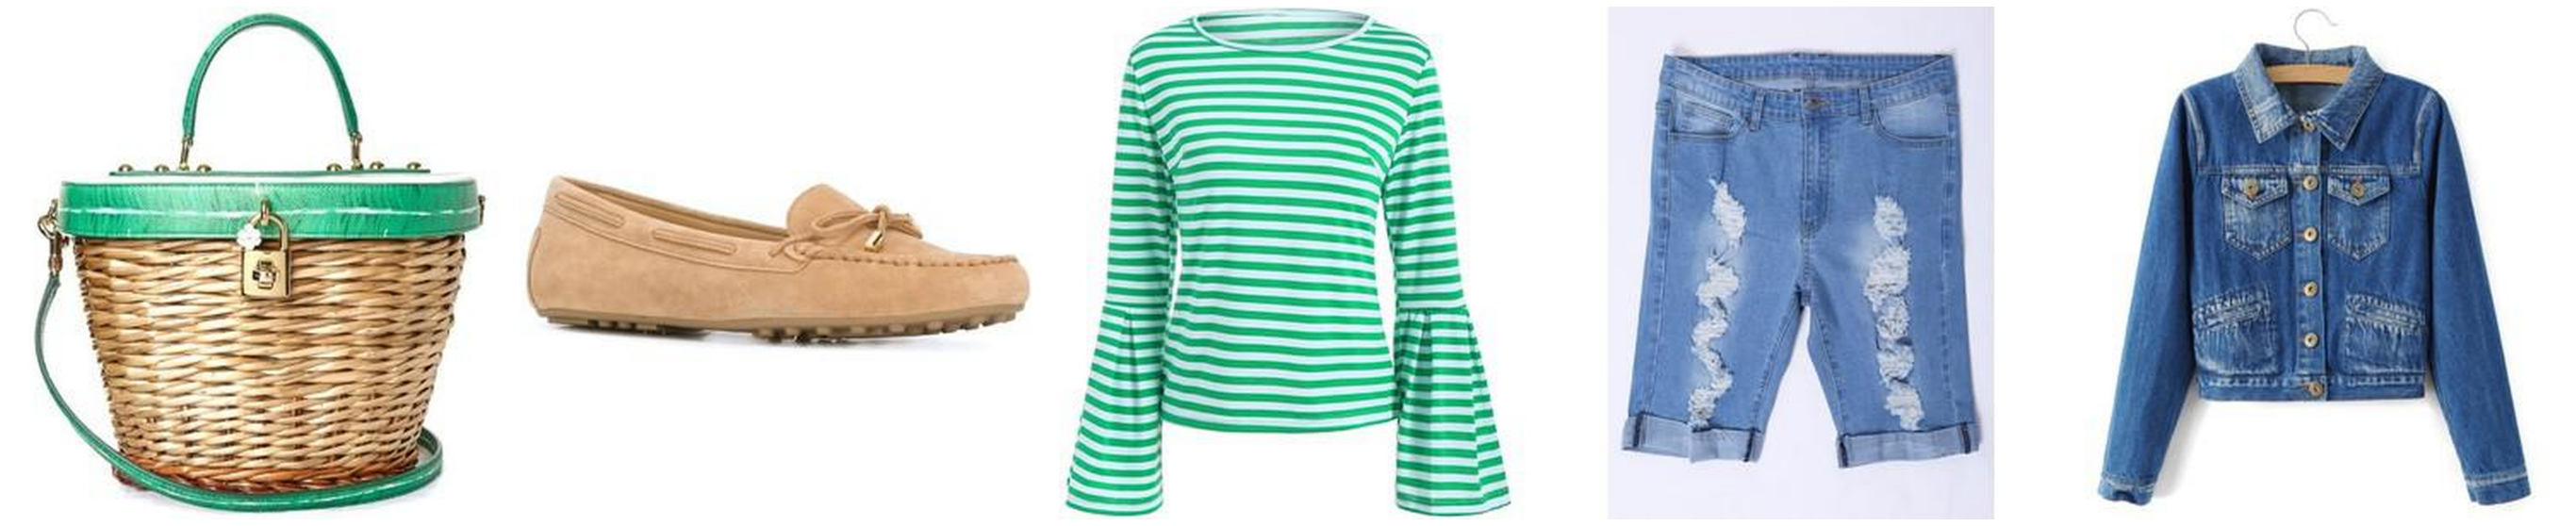

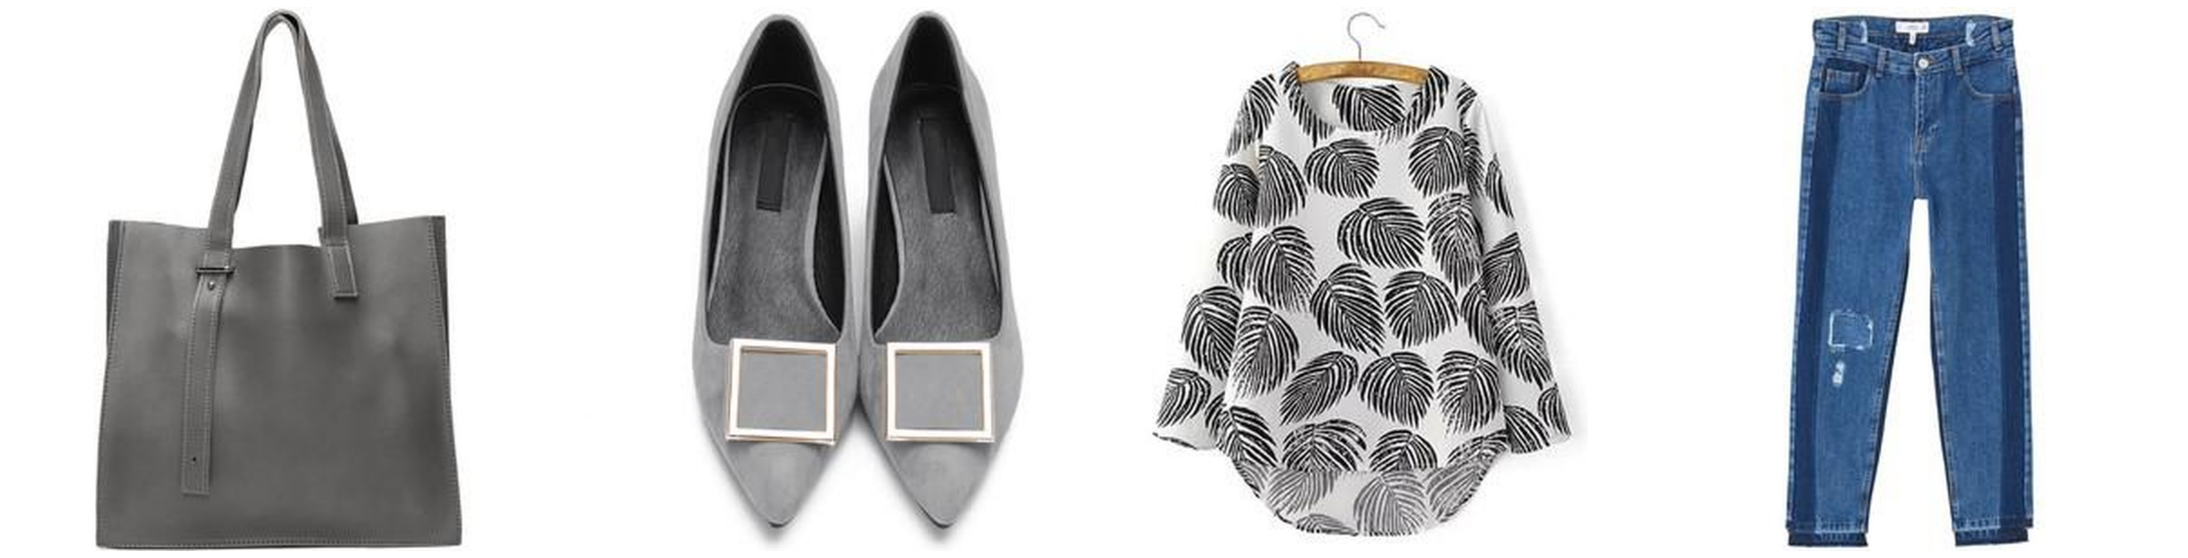

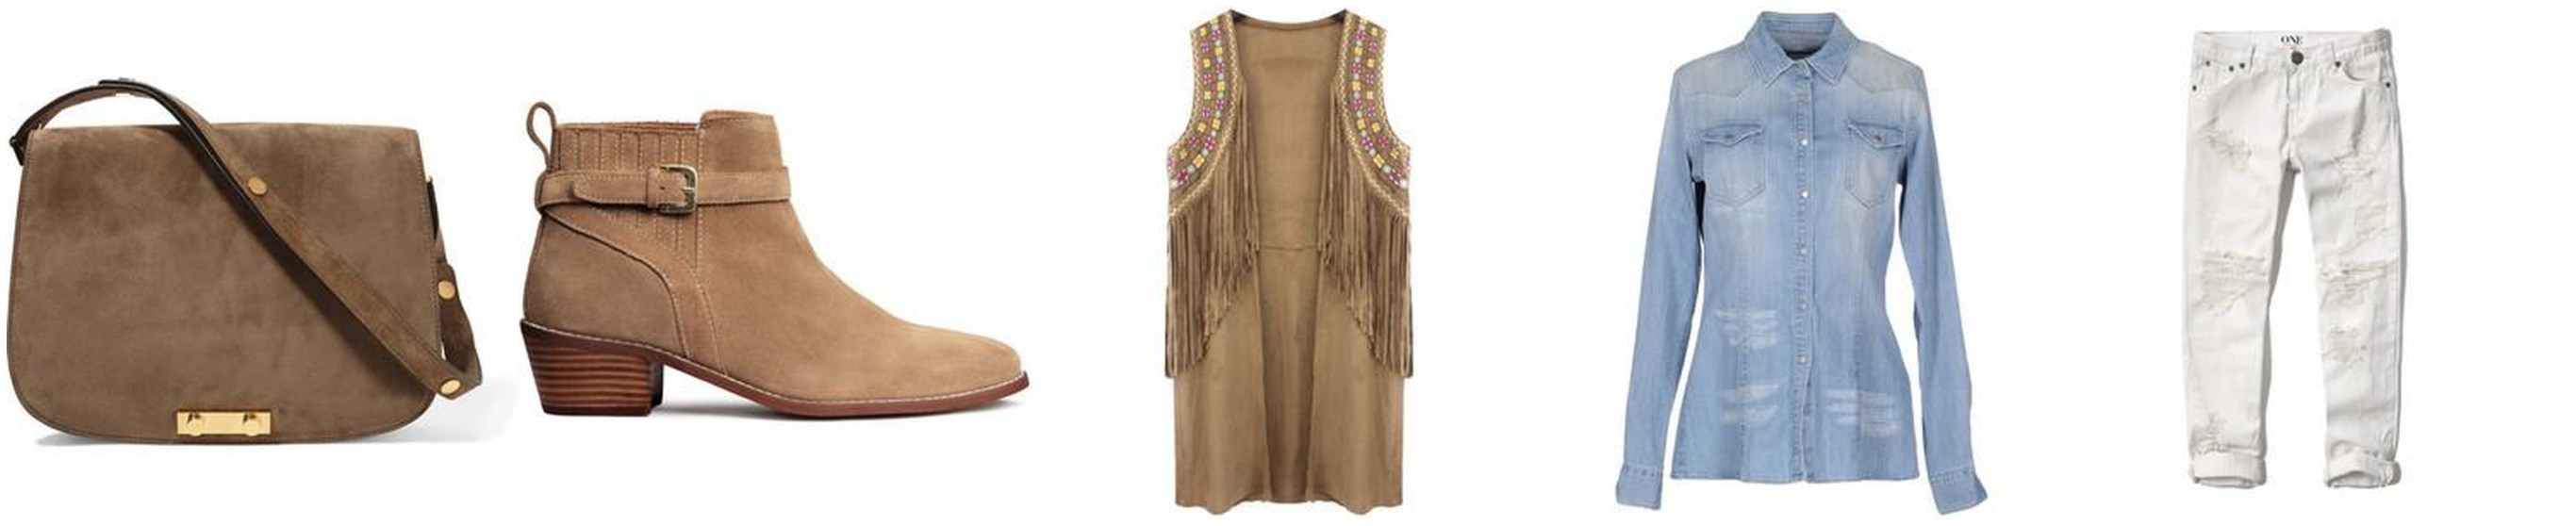

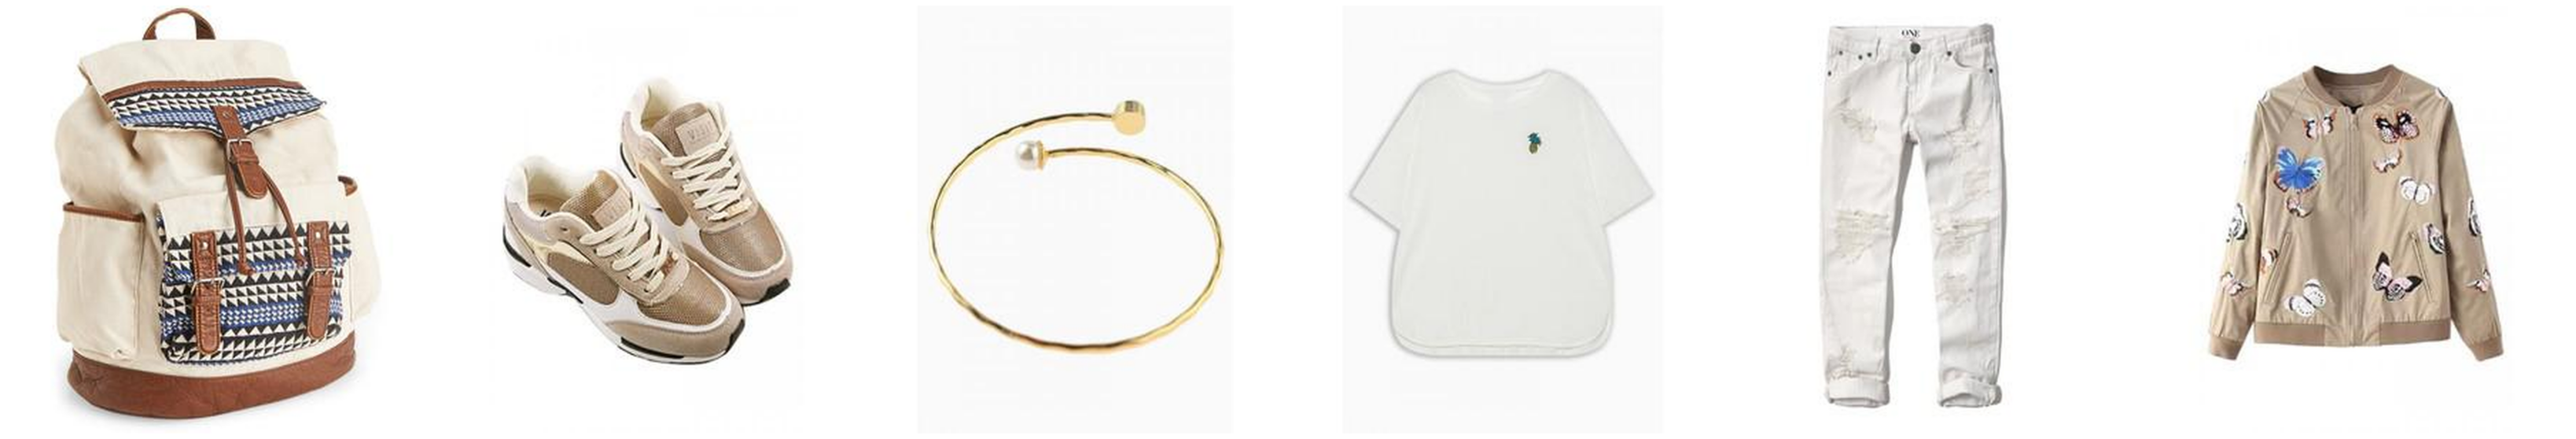

In [17]:
for board in boards:
    displayBoard(board)

In [24]:
descriptions = [get_descriptions_from_outfits(board) for board in boards][0]
outfit_ids = boards
map_descriptions_to_outfits = {}
# for i in range(len(descriptions)):
#     map_descriptions_to_outfits[descriptions[i]] = outfit_ids[i]
# for i, description in enumerate(descriptions):
#     map_descriptions_to_outfits[description] = outfit_ids[i]

print(descriptions)
print(outfit_ids)

['dolce gabbana banana leaf-print leather (bags)', 'michael kors daisy loafers (shoes)', 'striped bell sleeve tee (tops)', 'casual denim bleach wash shorts (bottoms)', 'bleach wash jeans jacket (outerwear)']
['217084517', '224935309', '193200102', '172550127']


In [25]:
prompt = "Womens Clothing to wear during Hot, sunny. Not like A fashion look from January 2015 featuring preppy shirts, beige jeans and leather oxfords. Browse and shop related looks"

In [26]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
model = DistilBertForMultipleChoice.from_pretrained("distilbert-base-cased")
labels = labels = torch.tensor(0).unsqueeze(0) #not needed?

tokenizer_input = []
for description in descriptions:
    tokenizer_input.append([prompt, description])

encoding = tokenizer(tokenizer_input, return_tensors="pt", padding=True)

outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()}, labels=labels)  # batch size is 1
logits = outputs.logits
predicted_label = torch.argmax(logits, dim=1)
logits_list = logits.tolist()

paired_list = list(zip(descriptions, logits_list[0]))

sorted_pairs = sorted(paired_list, key=lambda x: x[1], reverse=True)

sorted_elements = [element for element, score in sorted_pairs]

print(predicted_label.item())
print(sorted_elements)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForMultipleChoice: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN thi

1
['michael kors daisy loafers (shoes)', 'striped bell sleeve tee (tops)', 'dolce gabbana banana leaf-print leather (bags)', 'bleach wash jeans jacket (outerwear)', 'casual denim bleach wash shorts (bottoms)']


In [27]:
# Map sorted descriptions back to outfits and display the board
sorted_board = []
for i in range(len(sorted_elements)):
    sorted_board.append(map_descriptions_to_outfits[sorted_elements[i]])

KeyError: 'michael kors daisy loafers (shoes)'

In [28]:
for board in sorted_board:
    displayBoard(board)

### Return the style boards for the nearest items. Extract from inverted index